In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
import joblib                                                                                                                                            
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter

In [2]:
data = pd.read_table('。。/data-2/total4.15.txt',sep='\t',index_col=0)

data_gt= data.loc[:, data.columns.str.contains('BC|NT|MC|PC')].T
data_gt = data_gt.apply(pd.to_numeric)
data_gt = data_gt.drop(index=['BC5.1', 'BC5.3'])
data_gt = data_gt.apply(pd.to_numeric)
data_gt.fillna(0, inplace=True) 
data_gt.columns = data['ID']
# data_gt = data_gt.loc[:, (data_gt != 0).any(axis=0)]
# data_gt

data_fjg= data.loc[:, ~data.columns.str.contains('BC|NT|MC|PC')].T
data_fjg.columns = data_fjg.iloc[0]
data_fjg = data_fjg[1:]
data_fjg = data_fjg.sort_index()
data_fjg = data_fjg.replace("#DIV/0!", 0)
data_fjg = data_fjg.apply(pd.to_numeric)
data_fjg.fillna(0, inplace=True) 
# data_fjg = data_fjg.loc[:, (data_fjg != 0).any(axis=0)]
# data_fjg

print(data_fjg.shape,data_gt.shape) 


(54, 2718) (35, 2718)


In [3]:
from scipy.stats import pearsonr

pearson_corr_values = []
for i in range(len(data_fjg)):
    corr_values = []
    for j in range(len(data_gt)):
        corr, _ = pearsonr(data_fjg.iloc[i], data_gt.iloc[j])
        corr_values.append(corr)
    pearson_corr_values.append(corr_values)

pearson_corr_matrix = pd.DataFrame(pearson_corr_values, index=data_fjg.index, columns=data_gt.index)
pearson_corr_matrix['sum'] = pearson_corr_matrix.sum(axis=1)
# pearson_corr_matrix

pearson_corr_matrix['label'] = np.where(pearson_corr_matrix['sum'] > 1.5, 1, 0) #总和大于0.5，设置label为1
# similarity_matrix
len(pearson_corr_matrix[pearson_corr_matrix['label'] == 1])

data = pd.concat([data_fjg, data_gt])
data = data.loc[:, (data != 0).any(axis=0)]
X = data

Y = pearson_corr_matrix['label'].tolist() + [1] * len(data_gt)
Y = np.array(Y)

print(X.shape,Y.shape) 
Counter(Y)# To select 13 as 1 and 30 as 0, the baseline is guaranteed


(89, 2537) (89,)


Counter({0: 45, 1: 44})

In [167]:
# data = pearson_corr_matrix['label']
# data.index = data.index.astype(float) 
# data = data.sort_index() 
# data.to_csv("fjg_label.csv")

In [4]:
# Re-standardization and normalization
X  = Normalizer().fit_transform(X)
# X  = StandardScaler().fit_transform(X)
X  = MinMaxScaler().fit_transform(X)

# test

In [422]:
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

# Select half of the best features using SelectKBest, based on the ANOVA F value
select_k_best = SelectKBest(f_classif, k= int(X.shape[1]/5))
X_selected = select_k_best.fit_transform(X, Y)
X_select_k= select_k_best.get_support(indices=True)
len(X_select_k)


all_f = data_fjg.columns.tolist()
feature = [all_f[i] for i in X_select_k ]
print(len(feature),feature)

# The first step features the filtered data
X_g = X[:, X_select_k] 

rfc = GradientBoostingClassifier(n_estimators=100,random_state=42,learning_rate=0.01,max_depth=3)
n = 100
sfm = SelectFromModel(rfc, max_features = n) 
X_sn_new = sfm.fit_transform(X_g, Y)
print(X_sn_new.shape)

feature_importance = sfm.estimator_.feature_importances_
non_zero_indices = sfm.get_support(indices=True)
non_zero_indices = non_zero_indices.tolist()
all_f = data_fjg.columns.tolist()
feature = [all_f[i] for i in non_zero_indices]
print(len(feature),feature)

X_k = X_g[:, non_zero_indices]
print(X_k.shape,Y.shape)
non_zero_indices

/data/public/dulin/miniconda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [  10   34   36   77   78   91  107  114  119  184  186  188  205  223
  234  240  243  256  258  260  262  269  276  306  308  325  334  364
  372  390  391  394  400  405  409  427  443  451  452  453  459  466
  487  499  518  520  531  533  538  556  560  571  575  579  583  608
  625  652  680  684  695  700  711  712  715  722  725  730  745  754
  761  774  807  823  840  860  868  882  889  917  919  923  939  959
  966  969  974  975 1011 1049 1050 1056 1064 1065 1083 1084 1118 1160
 1163 1174 1175 1199 1201 1218 1220 1225 1227 1243 1244 1251 1263 1280
 1292 1304 1308 1332 1335 1343 1351 1354 1357 1365 1382 1385 1398 1419
 1434 1452 1481 1483 1492 1500 1504 1519 1559 1571 1572 1602 1606 1608
 1653 1665 1667 1679 1701 1711 1746 1767 1768 1771 1777 1794 1802 1824
 1825 1836 1851 1852 1853 1882 1889 1898 1903 1910 1940 1962 2005 2007
 2031 2035 20

543 ['501-19-9', '20126-76-5', '2922-51-2', '1000197-16-1', '77-42-9', '186302-24-9', '3026-45-7', '1000411-62-4', '547-65-9', '644-30-4', '1000210-42-6', '4940-11-8', '2743-60-4', '17431-03-7', '5283-66-9', '753-70-8', '63366-65-4', '93957-98-3', '274-07-7', '505-10-2', '90073-44-2', '544-77-4', '513-86-0', '112-96-9', '124-19-6', '1000145-43-8', '1000406-37-8', '140-67-0', '98-55-5', '35178-55-3', '1000315-10-3', '25336-68-9', '4406-72-8', '18829-56-6', '2082-79-3', '14803-30-6', '339589-41-2', '7397-46-8', '1000489-22-1', '1333142-61-2', '62183-79-3', '4023-00-1', '61142-73-2', '74752-99-1', '1010164-25-9', '123-94-4', '872-05-9', '128260-98-0', '62338-11-8', '123-51-3', '1000164-33-6', '1000396-96-5', '14389-13-0', '1152113-44-4', '108-39-4', '1000368-55-9', '7452-79-1', '53864-08-7', '2305-05-7', '14667-55-1', '563-80-4', '92276-84-1', '183969-41-7', '468712-10-9', '64780-32-1', '1000130-31-9', '1000349-95-7', '1000296-57-2', '82304-66-3', '24034-73-9', '13183-79-4', '29743-97-3',

[30,
 102,
 122,
 153,
 157,
 187,
 264,
 278,
 286,
 287,
 291,
 306,
 319,
 324,
 355,
 384,
 403,
 417,
 430,
 434,
 436,
 444,
 466,
 497,
 501,
 527,
 540]

In [423]:
# Create a 10fold cross-validation object
def train(X_k, Y):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []
    auc_scores = []
    recall = []
    precision = []
    tpr_list = []
    fpr_list = []

    accuracies_train = []
    f1_scores_train = []
    auc_scores_train = []
    recall_train = []
    precision_train = []
    tpr_list_train = []
    fpr_list_train = []

    for train_idx, test_idx in cv.split(X_k, Y):
        X_train, X_test = X_k[train_idx], X_k[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        rfc.fit(X_train, Y_train)
        #train
        X_pred = rfc.predict(X_train)
        accuracy = accuracy_score(Y_train, X_pred)
        re = metrics.recall_score(Y_train, X_pred)
        pr = metrics.precision_score(Y_train, X_pred)
        f1 = f1_score(Y_train, X_pred)
        auc1 = roc_auc_score(Y_train, rfc.predict_proba(X_train)[:,1])
        fpr, tpr, _ = roc_curve(Y_train,  rfc.predict_proba(X_train)[:,1])

        accuracies_train.append(accuracy)
        f1_scores_train.append(f1)
        auc_scores_train.append(auc1)
        recall_train.append(re)
        precision_train.append(pr)
        tpr_list_train.append(tpr)
        fpr_list_train.append(fpr)

        #test
        Y_pred = rfc.predict(X_test)
        accuracy = accuracy_score(Y_test, Y_pred)
        re = metrics.recall_score(Y_test, Y_pred)
        pr = metrics.precision_score(Y_test, Y_pred)
        f1 = f1_score(Y_test, Y_pred)
        auc1 = roc_auc_score(Y_test, rfc.predict_proba(X_test)[:,1])
        fpr, tpr, _ = roc_curve(Y_test,  rfc.predict_proba(X_test)[:,1])
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        accuracies.append(accuracy)
        recall.append(re)
        precision.append(pr)
        f1_scores.append(f1)
        auc_scores.append(auc1)

    # print("Train result")
    # for i, (accuracy,re, f1, auc) in enumerate(zip(accuracies_train, recall_train,f1_scores_train, auc_scores_train), 1):
    #     print(f'Fold {i}: Accuracy = {accuracy:.4f}, Recall = {re:.4f},F1 Score = {f1:.4f}, AUC = {auc:.4f}')

    average_accuracy = sum(accuracies_train) / len(accuracies_train)
    average_recall = sum(recall_train) / len(recall_train)
    average_f1 = sum(f1_scores_train) / len(f1_scores_train)
    average_auc = sum(auc_scores_train) / len(auc_scores_train)
    average_precision = sum(precision_train) / len(precision_train)


    # print(f'Average Accuracy = {average_accuracy:.4f}')
    # print(f'Average Recall = {average_recall:.4f}')
    # print(f'Average Precision = {average_precision:.4f}')
    # print(f'Average F1 Score = {average_f1:.4f}')
    # print(f'Average AUC = {average_auc:.4f}')

    # print("Test result")
    # for i, (accuracy,re, f1, auc) in enumerate(zip(accuracies, recall,f1_scores, auc_scores), 1):
    #     print(f'Fold {i}: Accuracy = {accuracy:.4f}, Recall = {re:.4f},F1 Score = {f1:.4f}, AUC = {auc:.4f}')

    average_accuracy = sum(accuracies) / len(accuracies)
    average_recall = sum(recall) / len(recall)
    average_f1 = sum(f1_scores) / len(f1_scores)
    average_auc = sum(auc_scores) / len(auc_scores)
    average_precision = sum(precision) / len(precision)
    print(f'Average Accuracy = {average_accuracy:.4f}')
    print(f'Average Recall = {average_recall:.4f}')
    print(f'Average Precision = {average_precision:.4f}')
    print(f'Average F1 Score = {average_f1:.4f}')
    print(f'Average AUC = {average_auc:.4f}')

In [424]:
train(X_k, Y)

Average Accuracy = 0.8986
Average Recall = 0.9100
Average Precision = 0.9033
Average F1 Score = 0.8988
Average AUC = 0.9350


In [425]:
for i in non_zero_indices:
    new = [idx for idx in non_zero_indices if idx != i]
    print(i)
    X_k = X_g[:, new]
    feature = [all_f[i] for i in new]
    # print(len(feature))
    train(X_k, Y)

30
Average Accuracy = 0.8986
Average Recall = 0.9100
Average Precision = 0.9033
Average F1 Score = 0.8988
Average AUC = 0.9350
102
Average Accuracy = 0.8875
Average Recall = 0.8900
Average Precision = 0.9033
Average F1 Score = 0.8850
Average AUC = 0.9450
122
Average Accuracy = 0.8986
Average Recall = 0.9100
Average Precision = 0.9033
Average F1 Score = 0.8988
Average AUC = 0.9350
153
Average Accuracy = 0.8986
Average Recall = 0.9100
Average Precision = 0.9033
Average F1 Score = 0.8988
Average AUC = 0.9350
157
Average Accuracy = 0.8986
Average Recall = 0.9100
Average Precision = 0.9033
Average F1 Score = 0.8988
Average AUC = 0.9350
187
Average Accuracy = 0.8986
Average Recall = 0.9100
Average Precision = 0.9033
Average F1 Score = 0.8988
Average AUC = 0.9350
264
Average Accuracy = 0.8986
Average Recall = 0.9100
Average Precision = 0.9033
Average F1 Score = 0.8988
Average AUC = 0.9400
278
Average Accuracy = 0.8986
Average Recall = 0.9100
Average Precision = 0.9033
Average F1 Score = 0.898

In [106]:
# new = non_zero_indices[1:]
# new = non_zero_indices[:1] + non_zero_indices[2:]
# new = non_zero_indices[:2] + non_zero_indices[3:]
# new = non_zero_indices[:3] + non_zero_indices[4:]
# new = non_zero_indices[:4] + non_zero_indices[5:]
# new = non_zero_indices[:5] + non_zero_indices[6:]
# new = non_zero_indices[:6] + non_zero_indices[7:]
# new = non_zero_indices[:7] + non_zero_indices[8:]
new = non_zero_indices[:8] + non_zero_indices[9:]
new = non_zero_indices[:9] + non_zero_indices[10:]
X_k = X_g[:, new]
print(X_k.shape,Y.shape)

feature = [all_f[i] for i in new]
print(len(feature),feature)
# for i in feature:
#     print(i)
new,non_zero_indices

(89, 9) (89,)
9 ['60160-17-0', '13183-79-4', '1000474-16-1', '1000298-95-7', '124-07-2', '1000150-50-3', '1000279-54-3', '2574-25-6', '1000315-09-5']


([94, 341, 395, 436, 625, 656, 1095, 1107, 1205],
 [94, 341, 395, 436, 625, 656, 1095, 1107, 1205, 1241])

# 7 features

In [5]:
rfc = GradientBoostingClassifier(n_estimators=2,random_state=42)
# from sklearn.linear_model import LogisticRegression
# rfc = LogisticRegression()
n = 7
sfm = SelectFromModel(rfc, max_features = n) 
X_sn_new = sfm.fit_transform(X, Y)
print(X_sn_new.shape)

feature_importance = sfm.estimator_.feature_importances_
non_zero_indices = sfm.get_support(indices=True)
non_zero_indices = non_zero_indices.tolist()
all_f = data.columns.tolist()
feature = [all_f[i] for i in non_zero_indices]
print(len(feature),feature)
for i in feature:
    print(i)
    
X_k = X[:, non_zero_indices]
print(X_k.shape,Y.shape)

for i in non_zero_indices:
    print(i,feature_importance[i])

(89, 7)
7 ['1000315-10-3', '1000150-45-1', '1000315-10-4', '1000149-94-5', '622-78-6', '1000152-34-3', '1000162-57-7']
1000315-10-3
1000150-45-1
1000315-10-4
1000149-94-5
622-78-6
1000152-34-3
1000162-57-7
(89, 7) (89,)
130 0.019632837690121783
673 0.019632837690122206
686 0.024220328114262345
1122 0.07705627705627717
1239 0.7548105547343364
1688 0.0804268366006173
1813 0.024220328114262814


In [128]:
Counter(np.round(feature_importance, 3))

Counter({0.0: 2530, 0.02: 2, 0.024: 2, 0.077: 1, 0.755: 1, 0.08: 1})

In [149]:
# new = non_zero_indices[1:]
# new = non_zero_indices[:1] + non_zero_indices[2:]
# new = non_zero_indices[:2] + non_zero_indices[3:]
# new = non_zero_indices[:3] + non_zero_indices[4:]
# new = non_zero_indices[:4] + non_zero_indices[5:]
# new = non_zero_indices[:5] + non_zero_indices[6:]
new = non_zero_indices[:6] + non_zero_indices[7:]

# new = non_zero_indices[:7] + non_zero_indices[8:]
# new = non_zero_indices[:8] + non_zero_indices[9:]
# new = non_zero_indices[:9] + non_zero_indices[10:]
X_k = X[:, new]
print(X_k.shape,Y.shape)

feature = [all_f[i] for i in new]
print(len(feature),feature)
# for i in feature:
#     print(i)
new,non_zero_indices

(89, 6) (89,)
6 ['140-67-0', '74630-80-1', '146934-31-8', '36144-40-8', '1116-52-5', '74841-63-7']


([130, 673, 686, 1122, 1239, 1688], [130, 673, 686, 1122, 1239, 1688, 1813])

In [6]:
# Create a 10fold cross validation object train
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
f1_scores = []
auc_scores = []
recall = []
precision = []
tpr_list = []
fpr_list = []

accuracies_train = []
f1_scores_train = []
auc_scores_train = []
recall_train = []
precision_train = []
tpr_list_train = []
fpr_list_train = []

for train_idx, test_idx in cv.split(X_k, Y):
    X_train, X_test = X_k[train_idx], X_k[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    rfc.fit(X_train, Y_train)
    #train
    X_pred = rfc.predict(X_train)
    accuracy = accuracy_score(Y_train, X_pred)
    re = metrics.recall_score(Y_train, X_pred)
    pr = metrics.precision_score(Y_train, X_pred)
    f1 = f1_score(Y_train, X_pred)
    auc1 = roc_auc_score(Y_train, rfc.predict_proba(X_train)[:,1])
    fpr, tpr, _ = roc_curve(Y_train,  rfc.predict_proba(X_train)[:,1])

    accuracies_train.append(accuracy)
    f1_scores_train.append(f1)
    auc_scores_train.append(auc1)
    recall_train.append(re)
    precision_train.append(pr)
    tpr_list_train.append(tpr)
    fpr_list_train.append(fpr)

    #test
    Y_pred = rfc.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    re = metrics.recall_score(Y_test, Y_pred)
    pr = metrics.precision_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    auc1 = roc_auc_score(Y_test, rfc.predict_proba(X_test)[:,1])
    fpr, tpr, _ = roc_curve(Y_test,  rfc.predict_proba(X_test)[:,1])
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    accuracies.append(accuracy)
    recall.append(re)
    precision.append(pr)
    f1_scores.append(f1)
    auc_scores.append(auc1)

# print("Train result")
for i, (accuracy,re, f1, auc) in enumerate(zip(accuracies_train, recall_train,f1_scores_train, auc_scores_train), 1):
    print(f'Fold {i}: Accuracy = {accuracy:.4f}, Recall = {re:.4f},F1 Score = {f1:.4f}, AUC = {auc:.4f}')

average_accuracy = sum(accuracies_train) / len(accuracies_train)
average_recall = sum(recall_train) / len(recall_train)
average_f1 = sum(f1_scores_train) / len(f1_scores_train)
average_auc = sum(auc_scores_train) / len(auc_scores_train)
average_precision = sum(precision_train) / len(precision_train)


print(f'Average Accuracy = {average_accuracy:.4f}')
print(f'Average Recall = {average_recall:.4f}')
print(f'Average Precision = {average_precision:.4f}')
print(f'Average F1 Score = {average_f1:.4f}')
print(f'Average AUC = {average_auc:.4f}')

Fold 1: Accuracy = 0.9875, Recall = 0.9750,F1 Score = 0.9873, AUC = 0.9988
Fold 2: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 3: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 4: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 5: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 6: Accuracy = 0.9875, Recall = 0.9744,F1 Score = 0.9870, AUC = 0.9987
Fold 7: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 8: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 9: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 10: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Average Accuracy = 0.9975
Average Recall = 0.9949
Average Precision = 1.0000
Average F1 Score = 0.9974
Average AUC = 0.9997


In [7]:
# "Test result"
for i, (accuracy,re, f1, auc) in enumerate(zip(accuracies, recall,f1_scores, auc_scores), 1):
    print(f'Fold {i}: Accuracy = {accuracy:.4f}, Recall = {re:.4f},F1 Score = {f1:.4f}, AUC = {auc:.4f}')


average_accuracy = sum(accuracies) / len(accuracies)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_scores) / len(f1_scores)
average_auc = sum(auc_scores) / len(auc_scores)
average_precision = sum(precision) / len(precision)
print(f'Average Accuracy = {average_accuracy:.4f}')
print(f'Average Recall = {average_recall:.4f}')
print(f'Average Precision = {average_precision:.4f}')
print(f'Average F1 Score = {average_f1:.4f}')
print(f'Average AUC = {average_auc:.4f}')

Fold 1: Accuracy = 0.7778, Recall = 0.7500,F1 Score = 0.7500, AUC = 0.8750
Fold 2: Accuracy = 0.8889, Recall = 1.0000,F1 Score = 0.8889, AUC = 0.9000
Fold 3: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 4: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 5: Accuracy = 0.8889, Recall = 0.7500,F1 Score = 0.8571, AUC = 0.8500
Fold 6: Accuracy = 0.6667, Recall = 0.4000,F1 Score = 0.5714, AUC = 0.9250
Fold 7: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 8: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 9: Accuracy = 0.8889, Recall = 1.0000,F1 Score = 0.9091, AUC = 0.8750
Fold 10: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Average Accuracy = 0.9111
Average Recall = 0.8900
Average Precision = 0.9383
Average F1 Score = 0.8977
Average AUC = 0.9425


In [83]:
feature_importance = rfc.feature_importances_
feature_importance = np.round(feature_importance, 2)
Counter(feature_importance)

Counter({0.0: 1, 0.03: 1, 0.05: 1, 0.07: 1, 0.77: 1, 0.06: 1, 0.02: 1})

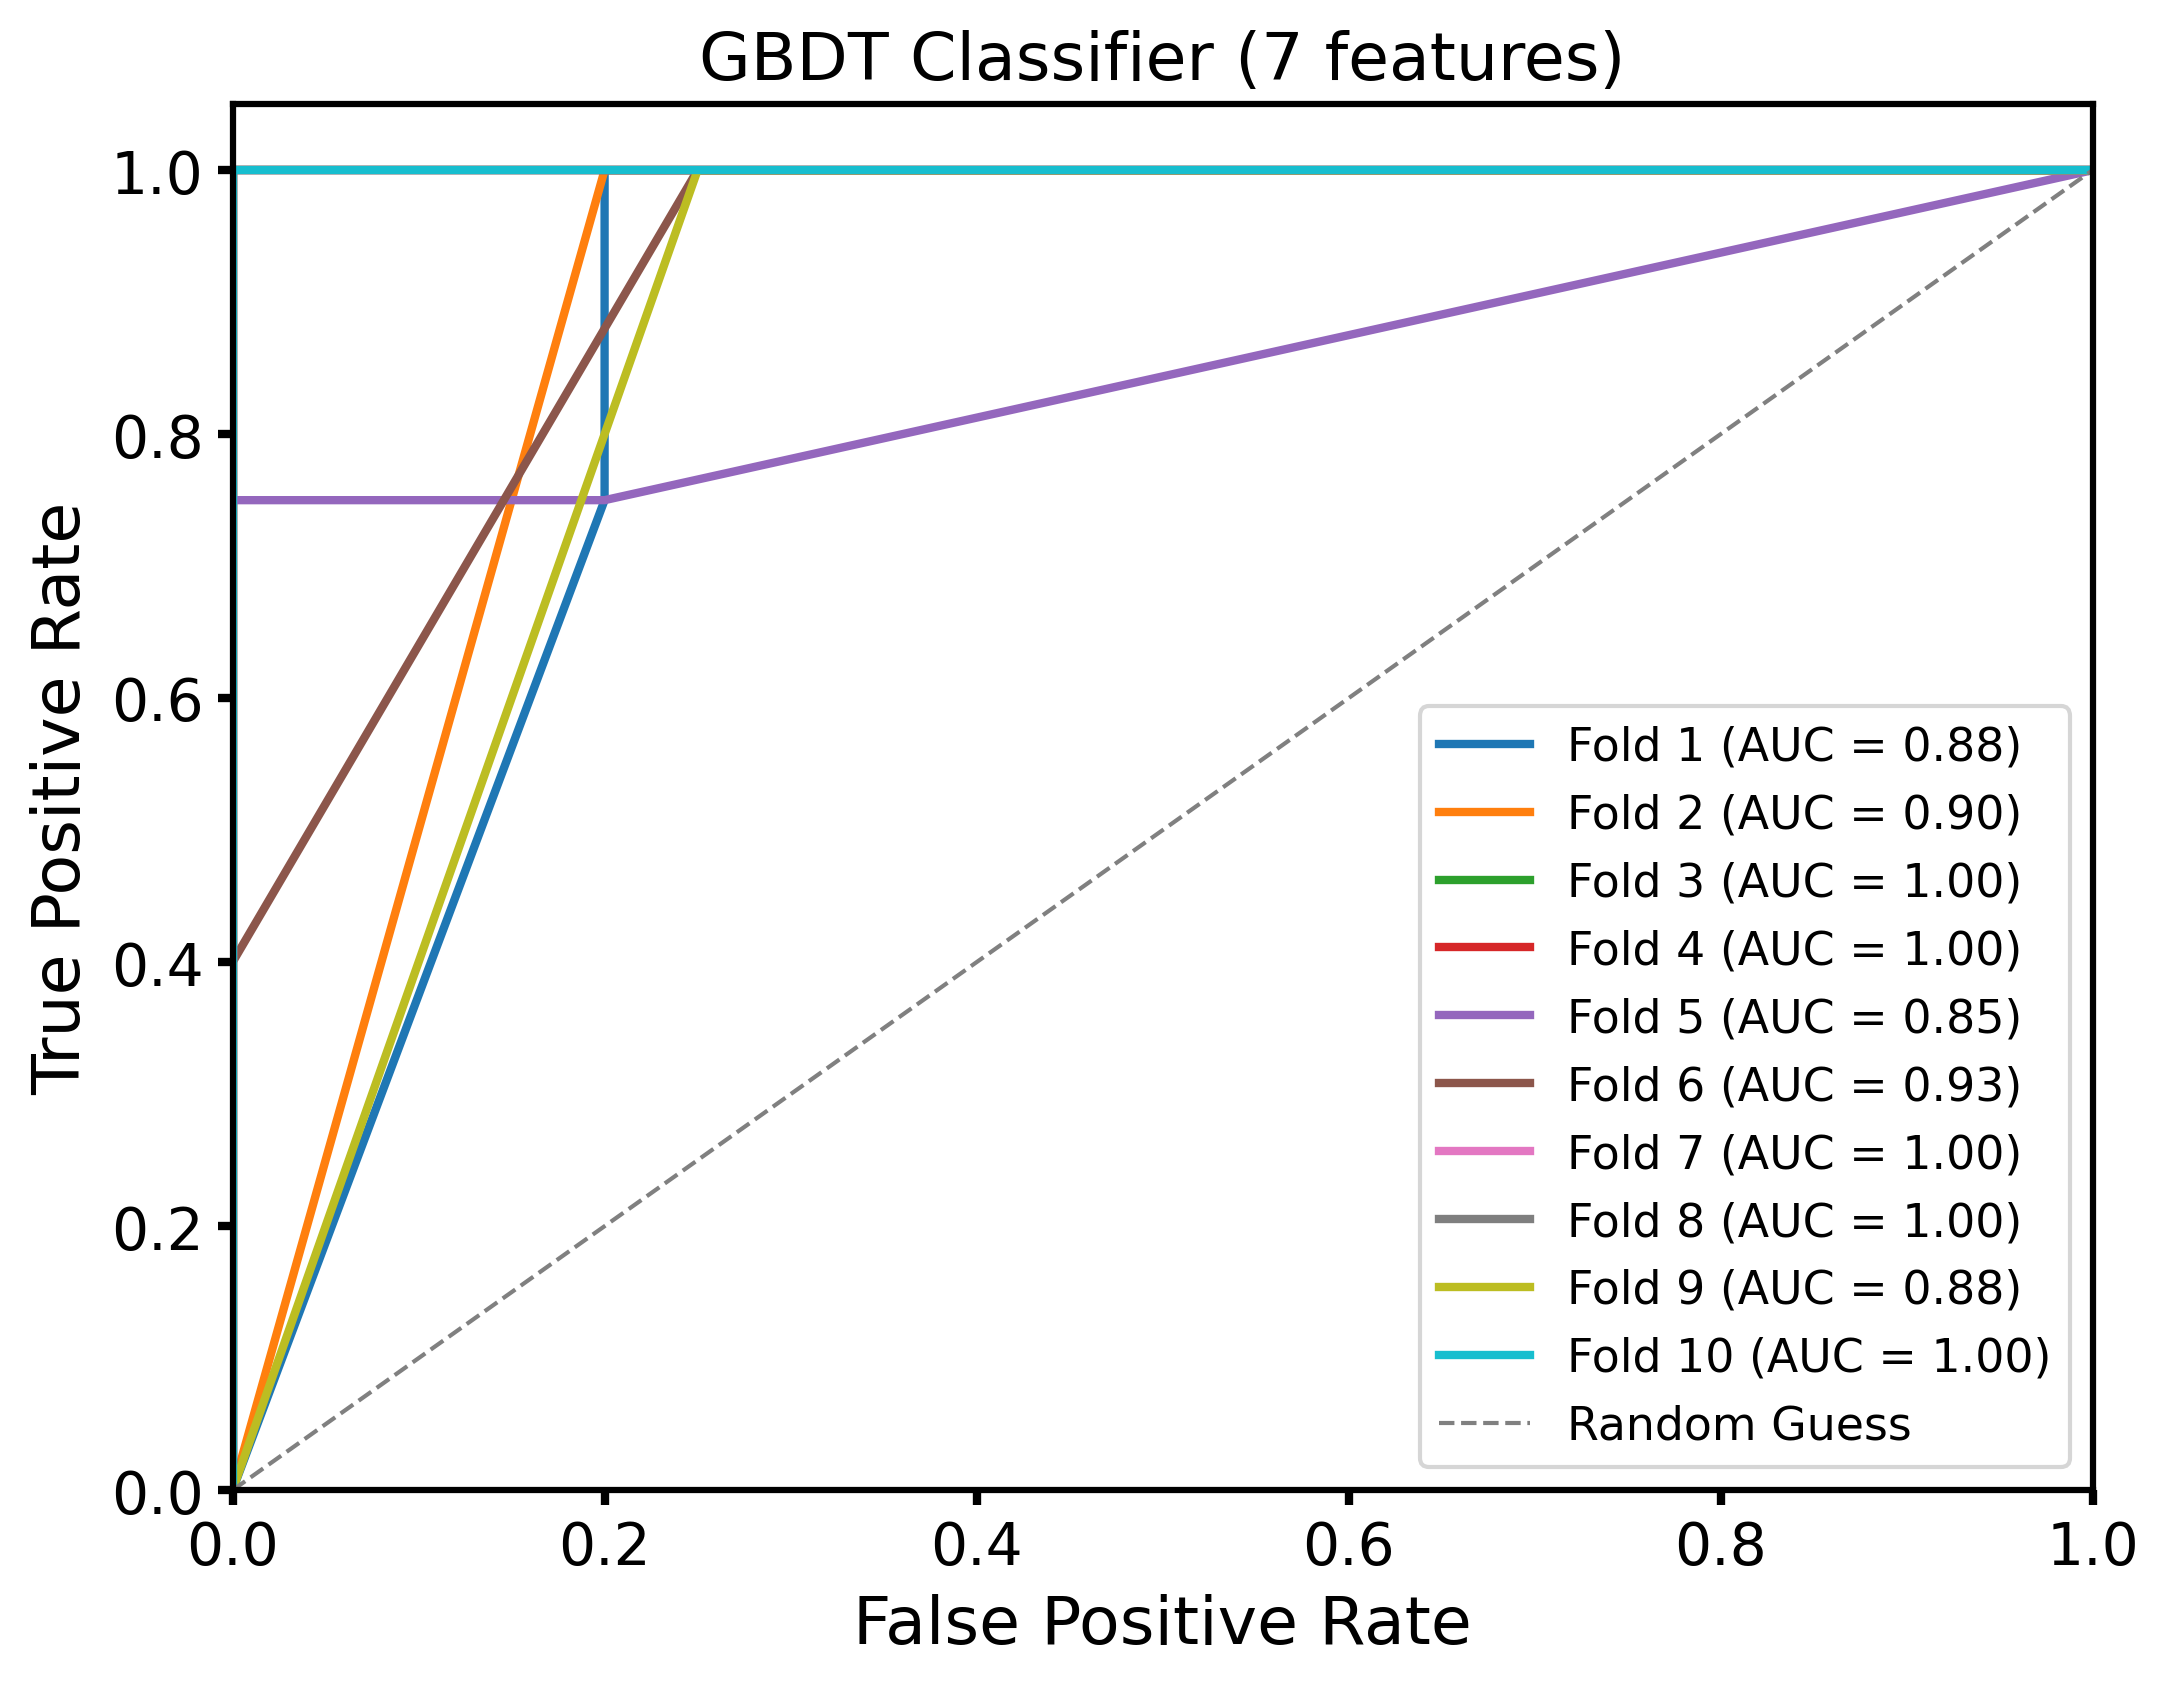

In [10]:

plt.figure(figsize=(8, 6),dpi=300)
for i, (tpr, fpr, roc_auc) in enumerate(zip(tpr_list, fpr_list, auc_scores), 1):
    plt.plot(fpr, tpr, lw=2, label=f'Fold {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=1,label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('GBDT Classifier (7 features)', fontsize=16)
plt.legend(loc='lower right', fontsize=11)



plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)

plt.gca().tick_params(axis='both', which='major', width=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig("../code-2/result/GBDT-7F-ROC.pdf")
plt.savefig("../code-2/result/GBDT-7F-ROC.png")
plt.show()

In [176]:
joblib.dump(rfc, "../code-2/result/GBDT_Classifier.joblib") #save model

['/data/public/dulin/fwwz/code-2/result/GBDT_Classifier.joblib']